# DeepWeeds - Image Classification - Using ResNet50 Model

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil

seed = 679
tf.random.set_seed(seed)

2024-02-27 00:09:28.201245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 00:09:28.201360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 00:09:28.336033: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

## Splitting Data into Train:Valid:Test Splits (60:40:40)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 2 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])
# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break
        
# # trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# # train_data = pd.DataFrame({"Filename":trax,"label":tray})

# # trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# # valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# # test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 3 out of 5 folds
-------------------------------------------------



In [8]:
## Using Folds Used in The DeepWeeds Paper
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  605  644  610  5464 	Total: (10506, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  205  213  202  215  203  1821 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)

In [9]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)
        
        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.utils import class_weight

def getWeightedClass(data, power=1, col="Label"):

    class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(data_info[col]),
                                                 y=data_info[col])

    return  { label: pow(class_weights[label],power) for label in range(len(class_weights)) }

getWeightedClass(data_info)

{0: 1.729283950617284,
 1: 1.8284252297410193,
 2: 1.8869490246793836,
 3: 1.9035659926070885,
 4: 1.8318685917555975,
 5: 1.9280916198656535,
 6: 1.8114007862611214,
 7: 1.9148075240594926,
 8: 0.21364423945139957}

In [36]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()
    
    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP
        
        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)
        
        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)
        
        false_rate.append((fP_Rate,accuracy))
    
    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()          
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()      
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()
    
def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model.predict_on_batch(batch[0])))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob

def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

# Creating Dateset ImageGenerator

In [12]:
IMG_SIZE=(256,256,3)
oversampling = 1 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

Oversampling 1 times for labels [0 1 7 6 4 3 5 2]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [21]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

Found 15548 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.


## Displaying Sample Images

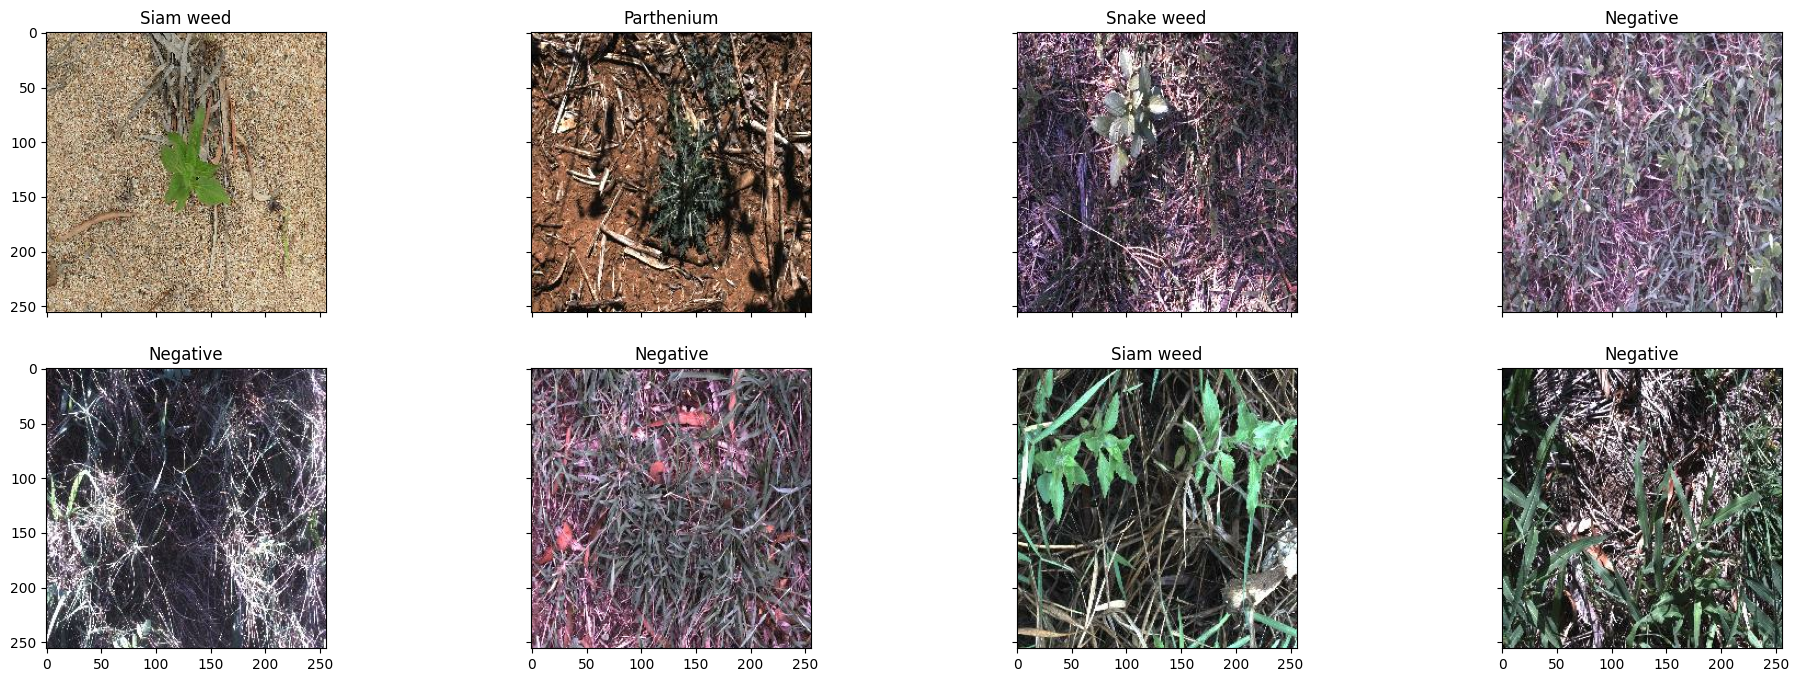

In [16]:
#image visualization

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# ResNet50

In [17]:
# prompt: code to implement resnet

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import ResNet50V2, resnet_v2

def buildResNetModel(train_resnet=False):
    # Load the ResNet50 model with weights pre-trained on ImageNet.
    base_model = ResNet50V2(weights='imagenet', include_top=False)
    base_model.trainable = train_resnet

    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE)

    # PreProcess the input.
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Resizing(224, 224)(x)
    
    ## Augmentation
    x = layers.RandomBrightness(0.25, (0, 1),seed=seed)(x)
    x = layers.RandomContrast(0.1, seed=seed)(x)
    x = layers.GaussianDropout(0.05, seed=seed)(x)
    x = layers.RandomFlip(seed=seed)(x)
    x = layers.RandomRotation(0.5, seed=seed)(x)
    x = layers.RandomTranslation(0.2, 0.2, seed=seed)(x)
    x = layers.RandomZoom(0.2, 0.2, seed=seed)(x)

    # Pass the input through the pre-trained ResNet50 model.
    x = base_model(x, training=train_resnet)    
    x = layers.Dropout(0.2)(x) 
    
    ## Add a global average pooling layer.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    
    # Add a final output layer with 10 units and softmax activation.
    outputs = layers.Dense(9, activation='softmax', name='Classifier')(x)

    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name='DeepWeeds-ResNet50')
    return model

## Trial 1

In [18]:
model = buildResNetModel(train_resnet=True)
model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "DeepWeeds-ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 random_brightness (RandomB  (None, 224, 224, 3)       0         
 rightness)                                                      
                                                                 
 random_contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                 

In [19]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=3e-2),
          metrics=['accuracy'])
# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/100


2024-02-27 00:41:07.644378: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708994471.708263      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


972/972 [==============================] - 144s 117ms/step - loss: 1.1224 - accuracy: 0.5949 - val_loss: 0.7453 - val_accuracy: 0.7410
Epoch 2/100
972/972 [==============================] - 113s 116ms/step - loss: 0.8025 - accuracy: 0.7138 - val_loss: 0.7280 - val_accuracy: 0.7421
Epoch 3/100
972/972 [==============================] - 113s 116ms/step - loss: 0.6952 - accuracy: 0.7551 - val_loss: 0.6624 - val_accuracy: 0.7633
Epoch 4/100
972/972 [==============================] - 113s 116ms/step - loss: 0.6488 - accuracy: 0.7708 - val_loss: 0.5663 - val_accuracy: 0.8015
Epoch 5/100
972/972 [==============================] - 113s 116ms/step - loss: 0.5898 - accuracy: 0.7906 - val_loss: 0.5560 - val_accuracy: 0.8064
Epoch 6/100
972/972 [==============================] - 113s 116ms/step - loss: 0.5584 - accuracy: 0.8041 - val_loss: 0.5340 - val_accuracy: 0.8207
Epoch 7/100
972/972 [==============================] - 113s 116ms/step - loss: 0.5179 - accuracy: 0.8149 - val_loss: 0.5292 - val_

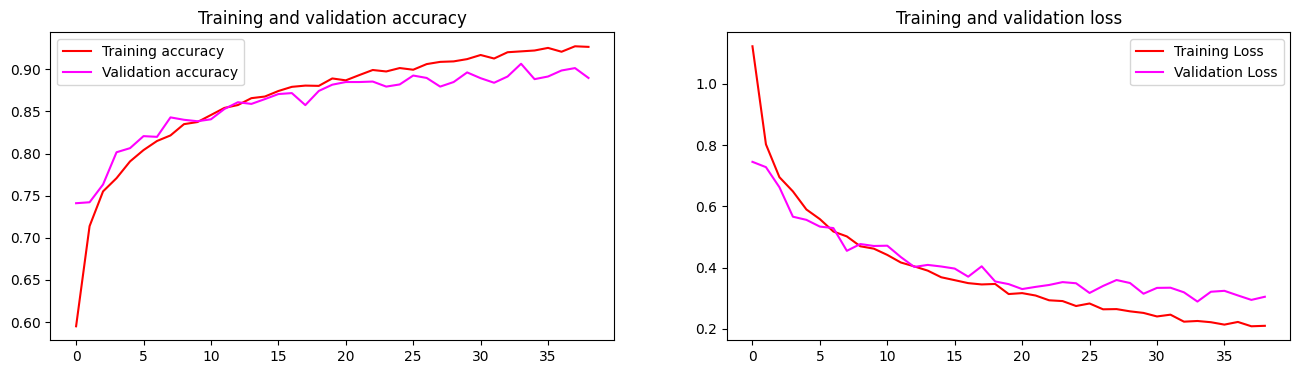

CPU times: user 1h 13min 58s, sys: 3min 6s, total: 1h 17min 5s
Wall time: 1h 13min 55s


In [38]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Model")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
219/219 [==============================] - 8s 35ms/step - loss: 0.3012 - accuracy: 0.8966
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.75105   0.79111   0.77056       225
       Lantana    0.90452   0.84906   0.87591       212
   Parkinsonia    0.87931   0.99029   0.93151       206
    Parthenium    0.86878   0.93659   0.90141       205
Prickly acacia    0.85897   0.94366   0.89933       213
   Rubber vine    0.82979   0.96535   0.89245       202
     Siam weed    0.86784   0.91628   0.89140       215
    Snake weed    0.83333   0.83744   0.83538       203
      Negative    0.96030   0.90335   0.93096      1821

      accuracy                        0.90291      3502
     macro avg    0.86155   0.90368   0.88099      3502
  weighted avg    0.90663   0.90291   0.90351      3502


                False Positive Rate  Accuracy
Chinee apple               0.018004  0.791111
Lantana                    0.005775  0.849057
Parkinsonia                0.008495  0.990291
Parthenium                 0.008796  0.936585
Prickly acacia    

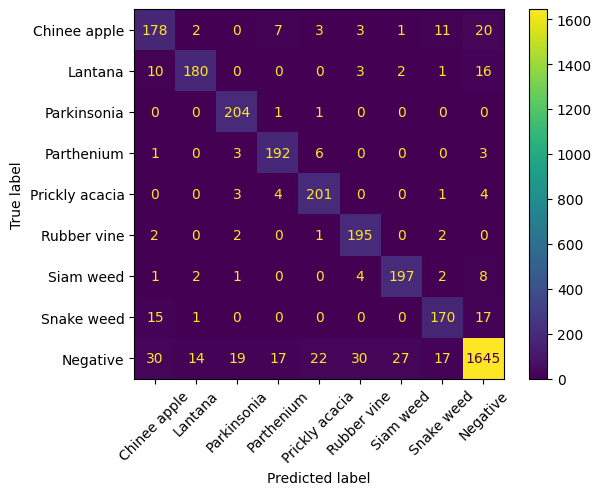

In [39]:
a, b = eval_model(model, validation_generator)

## Trial 2

Epoch 1/100


2024-02-27 02:04:56.672136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


972/972 [==============================] - 142s 119ms/step - loss: 0.1199 - accuracy: 0.9599 - val_loss: 0.2246 - val_accuracy: 0.9266
Epoch 2/100
972/972 [==============================] - 114s 117ms/step - loss: 0.1122 - accuracy: 0.9632 - val_loss: 0.2306 - val_accuracy: 0.9249
Epoch 3/100
972/972 [==============================] - 114s 117ms/step - loss: 0.1049 - accuracy: 0.9661 - val_loss: 0.2416 - val_accuracy: 0.9212
Epoch 4/100
972/972 [==============================] - 113s 117ms/step - loss: 0.1065 - accuracy: 0.9635 - val_loss: 0.2346 - val_accuracy: 0.9243
Epoch 5/100
972/972 [==============================] - 113s 117ms/step - loss: 0.1057 - accuracy: 0.9635 - val_loss: 0.2314 - val_accuracy: 0.9289
Epoch 6/100
972/972 [==============================] - 114s 117ms/step - loss: 0.0987 - accuracy: 0.9682 - val_loss: 0.2282 - val_accuracy: 0.9260
Epoch 6: early stopping
Saving the Checkpoint


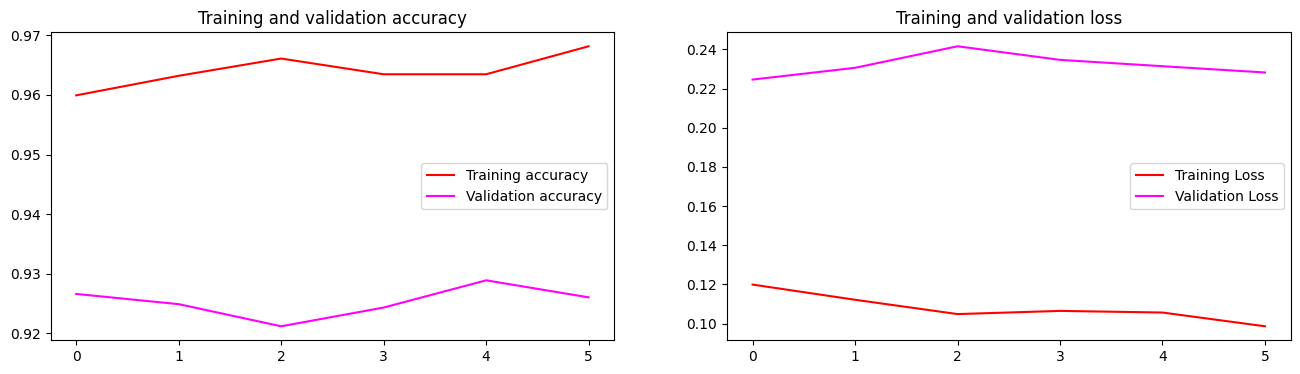

CPU times: user 11min 49s, sys: 28.9 s, total: 12min 18s
Wall time: 11min 51s


In [42]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=1e-5,  weight_decay=3e-3),
          metrics=['accuracy'])

# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
    )

print("Saving the Checkpoint")
model.save_weights("DeepWeeds-ResNet50-CheckPoint1.ckpt")

# Plot training results
plot_loss_acc(history2.history)

model.evaluate
219/219 [==============================] - 8s 37ms/step - loss: 0.2271 - accuracy: 0.9260
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.83983   0.86222   0.85088       225
       Lantana    0.87225   0.93396   0.90205       212
   Parkinsonia    0.92237   0.98058   0.95059       206
    Parthenium    0.86283   0.95122   0.90487       205
Prickly acacia    0.84874   0.94836   0.89579       213
   Rubber vine    0.90698   0.96535   0.93525       202
     Siam weed    0.90991   0.93953   0.92449       215
    Snake weed    0.83645   0.88177   0.85851       203
      Negative    0.97310   0.91378   0.94251      1821

      accuracy                        0.92262      3502
     macro avg    0.88583   0.93075   0.90721      3502
  weighted avg    0.92581   0.92262   0.92321      3502


                False Positive Rate  Accuracy
Chinee apple               0.011291  0.862222
Lantana                    0.008815  0.933962
Parkinsonia                0.005158  0.980583
Parthenium                 0.009402  0.951220
Prickly acacia    

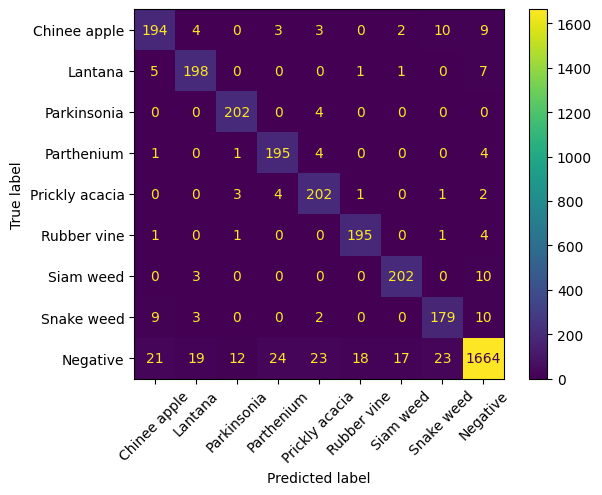

In [43]:
a, b = eval_model(model, validation_generator)

### Trial 3

Epoch 1/100


2024-02-27 02:23:14.696482: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


972/972 [==============================] - 142s 118ms/step - loss: 0.1131 - accuracy: 0.9618 - val_loss: 0.2404 - val_accuracy: 0.9169
Epoch 2/100
972/972 [==============================] - 114s 117ms/step - loss: 0.1116 - accuracy: 0.9615 - val_loss: 0.2618 - val_accuracy: 0.9160
Epoch 3/100
972/972 [==============================] - 114s 117ms/step - loss: 0.1125 - accuracy: 0.9618 - val_loss: 0.2356 - val_accuracy: 0.9269
Epoch 4/100
972/972 [==============================] - 114s 117ms/step - loss: 0.1139 - accuracy: 0.9619 - val_loss: 0.2333 - val_accuracy: 0.9278
Epoch 5/100
972/972 [==============================] - 114s 117ms/step - loss: 0.1081 - accuracy: 0.9648 - val_loss: 0.2339 - val_accuracy: 0.9220
Epoch 6/100
972/972 [==============================] - 114s 117ms/step - loss: 0.1061 - accuracy: 0.9637 - val_loss: 0.2364 - val_accuracy: 0.9289
Epoch 7/100
972/972 [==============================] - 114s 117ms/step - loss: 0.1074 - accuracy: 0.9634 - val_loss: 0.2416 - val_

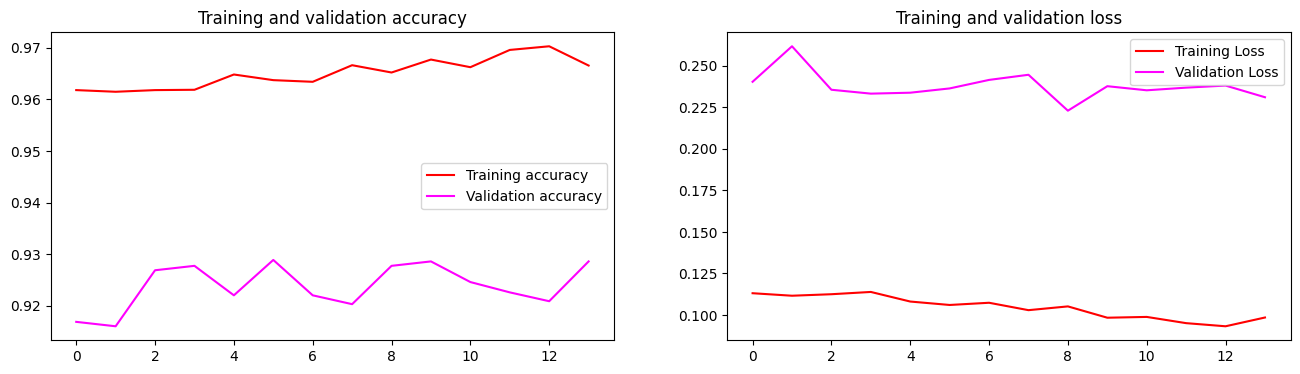

CPU times: user 27min 1s, sys: 1min 6s, total: 28min 7s
Wall time: 27min 2s


In [44]:
%%time
# weights = getWeightedClass(data_info, 1/2)
# print("Increasing Class-Weights",weights)

model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=5e-6,  weight_decay=3e-4),
  metrics=['accuracy'])

# Train the model
history3 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Checkpoint")
model.save_weights("DeepWeeds-ResNet50-CheckPoint2.ckpt")

# Plot training results
plot_loss_acc(history3.history)

model.evaluate
219/219 [==============================] - 8s 36ms/step - loss: 0.2400 - accuracy: 0.9278
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.85714   0.85333   0.85523       225
       Lantana    0.90741   0.92453   0.91589       212
   Parkinsonia    0.94811   0.97573   0.96172       206
    Parthenium    0.84615   0.96585   0.90205       205
Prickly acacia    0.83951   0.95775   0.89474       213
   Rubber vine    0.91628   0.97525   0.94484       202
     Siam weed    0.92166   0.93023   0.92593       215
    Snake weed    0.85922   0.87192   0.86553       203
      Negative    0.96888   0.92312   0.94544      1821

      accuracy                        0.92690      3502
     macro avg    0.89604   0.93086   0.91237      3502
  weighted avg    0.92941   0.92690   0.92733      3502


                False Positive Rate  Accuracy
Chinee apple               0.009765  0.853333
Lantana                    0.006079  0.924528
Parkinsonia                0.003337  0.975728
Parthenium                 0.010919  0.965854
Prickly acacia    

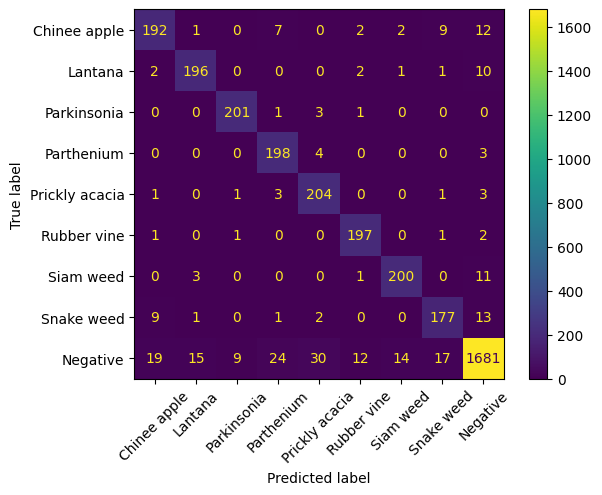

In [45]:
a, b = eval_model(model, validation_generator)

## Trial 4

Freezing layer resnet50v2
Epoch 1/100


2024-02-27 02:53:37.927064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


972/972 [==============================] - 49s 46ms/step - loss: 0.2087 - accuracy: 0.9291 - val_loss: 0.2183 - val_accuracy: 0.9335
Epoch 2/100
972/972 [==============================] - 44s 45ms/step - loss: 0.2016 - accuracy: 0.9339 - val_loss: 0.2155 - val_accuracy: 0.9346
Epoch 3/100
972/972 [==============================] - 44s 45ms/step - loss: 0.2020 - accuracy: 0.9323 - val_loss: 0.2133 - val_accuracy: 0.9358
Epoch 4/100
972/972 [==============================] - 44s 45ms/step - loss: 0.2041 - accuracy: 0.9329 - val_loss: 0.2112 - val_accuracy: 0.9358
Epoch 5/100
972/972 [==============================] - 44s 45ms/step - loss: 0.1931 - accuracy: 0.9366 - val_loss: 0.2098 - val_accuracy: 0.9369
Epoch 6/100
972/972 [==============================] - 44s 45ms/step - loss: 0.2005 - accuracy: 0.9321 - val_loss: 0.2085 - val_accuracy: 0.9375
Epoch 7/100
972/972 [==============================] - 44s 45ms/step - loss: 0.1948 - accuracy: 0.9366 - val_loss: 0.2072 - val_accuracy: 0.93

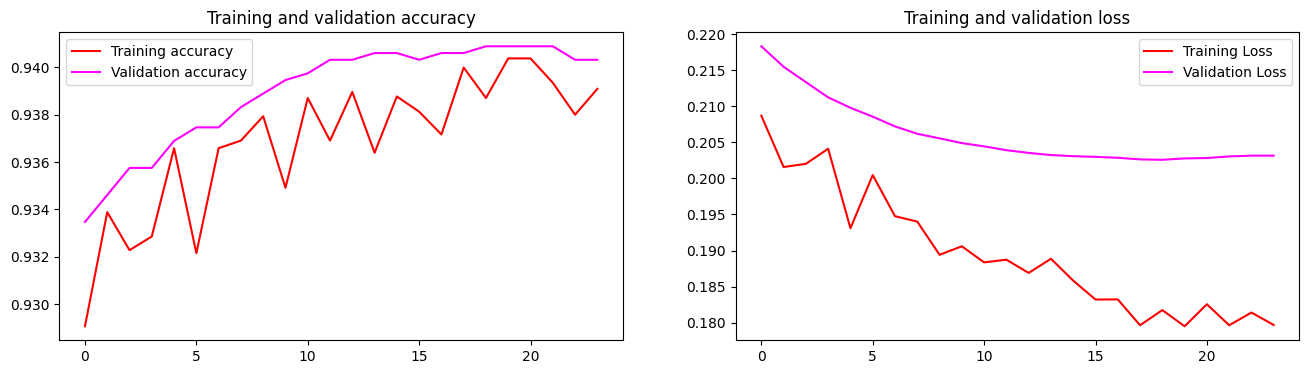

CPU times: user 17min 44s, sys: 1min 26s, total: 19min 11s
Wall time: 17min 47s


In [46]:
%%time
for layer in model.layers:
    if layer.name == 'resnet50v2':
        print("Freezing layer", layer.name)
        layer.trainable = False
        
model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=1e-6,  weight_decay=1e-4),
  metrics=['accuracy'])

# Train the model
history4 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping]
    )

print("Saving the Checkpoint")
model.save_weights("DeepWeeds-ResNet50-CheckPoint3.ckpt")

# Plot training results
plot_loss_acc(history4.history)

# Evaluations

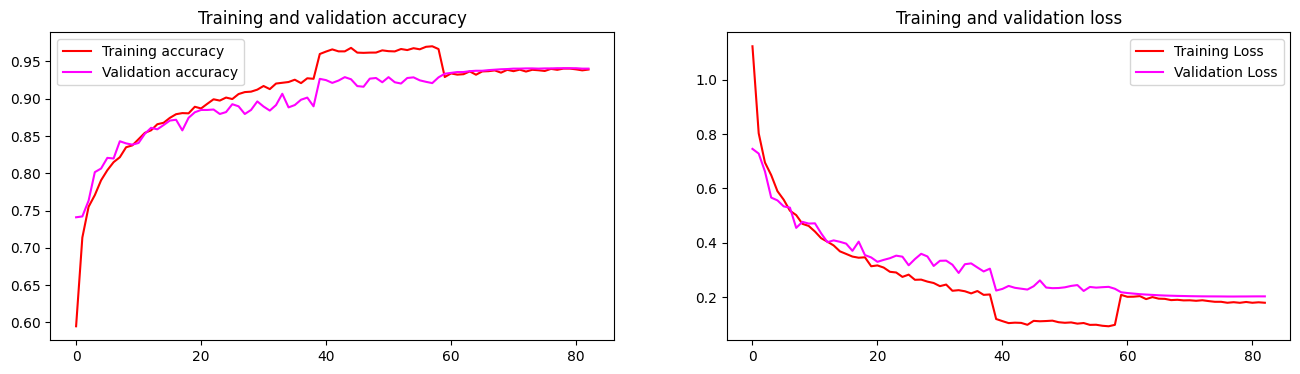

In [47]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])
    history[key].extend(history3.history[key])
    history[key].extend(history4.history[key])
    

plot_loss_acc(history)

model.evaluate
219/219 [==============================] - 7s 34ms/step - loss: 0.2026 - accuracy: 0.9409
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.91469   0.85778   0.88532       225
       Lantana    0.94762   0.93868   0.94313       212
   Parkinsonia    0.94366   0.97573   0.95943       206
    Parthenium    0.87611   0.96585   0.91879       205
Prickly acacia    0.90179   0.94836   0.92449       213
   Rubber vine    0.89238   0.98515   0.93647       202
     Siam weed    0.95349   0.95349   0.95349       215
    Snake weed    0.85581   0.90640   0.88038       203
      Negative    0.97110   0.94124   0.95594      1821

      accuracy                        0.94089      3502
     macro avg    0.91741   0.94141   0.92860      3502
  weighted avg    0.94236   0.94089   0.94109      3502


                False Positive Rate  Accuracy
Chinee apple               0.005493  0.857778
Lantana                    0.003343  0.938679
Parkinsonia                0.003641  0.975728
Parthenium                 0.008493  0.965854
Prickly acacia    

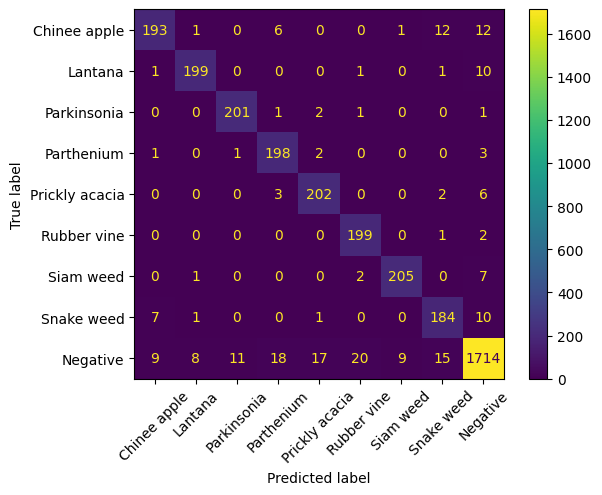

'Threshold = 0.1111111119389534'

In [48]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

thresholds = []
for i in range(len(a)):
    n_label = prediction_argmax(b[i])
    ap_label = np.argmax(b[i])
    a_label = a[i]

    if(n_label == a_label):
        thresholds.append(b[n_label])


rand_guess = np.mean(thresholds)
"Threshold = {}".format(rand_guess)

## Normal Evaluation

Normal Evaluation   
--------------------------------------------------------------------
model.evaluate
219/219 [==============================] - 8s 38ms/step - loss: 0.2031 - accuracy: 0.9414
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.87500   0.90222   0.88840       225
       Lantana    0.94836   0.94836   0.94836       213
   Parkinsonia    0.92237   0.98058   0.95059       206
    Parthenium    0.88532   0.94608   0.91469       204
Prickly acacia    0.92093   0.93396   0.92740       212
   Rubber vine    0.88991   0.96040   0.92381       202
     Siam weed    0.93578   0.94884   0.94226       215
    Snake weed    0.89268   0.90148   0.89706       203
      Negative    0.97391   0.94289   0.95815      1821

      accuracy                        0.94145      3501
     macro avg    0.91603   0.94053   0.92786      3501
  weighted avg    0.94270   0.94145   0.94173      3501


                False Positive Rate  Accuracy
Chinee apple               0.008852  0.902222
Lantana                    0.003345  0.948357
Parkinsonia                0.005159  0.980583
Parthenium                 0.007583  0.946078
Prickly acacia    

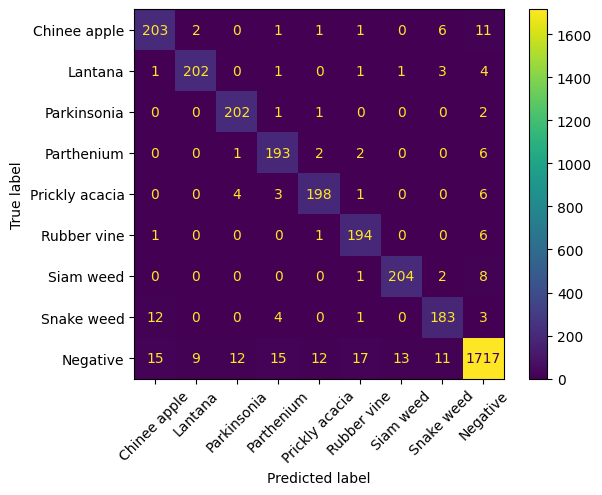

In [49]:
print("Normal Evaluation \
  \n--------------------------------------------------------------------")
a, b = eval_model(model, test_generator)

## Random Guess Threshold
> As applied by the paper DeepWeeds

Evaluation with Random Guess - As applied by the paper DeepWeeds   
--------------------------------------------------------------------
Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.81712   0.93333   0.87137       225
       Lantana    0.90265   0.95775   0.92938       213
   Parkinsonia    0.92237   0.98058   0.95059       206
    Parthenium    0.88532   0.94608   0.91469       204
Prickly acacia    0.88646   0.95755   0.92063       212
   Rubber vine    0.88991   0.96040   0.92381       202
     Siam weed    0.93578   0.94884   0.94226       215
    Snake weed    0.89268   0.90148   0.89706       203
      Negative    0.98305   0.92367   0.95243      1821

      accuracy                        0.93545      3501
     macro avg    0.90171   0.94552   0.92247      3501
  weighted avg    0.93887   0.93545   0.93610      3501


                False Positive Rate  Accuracy
Chinee apple               0.014347  0.933333
Lantana            

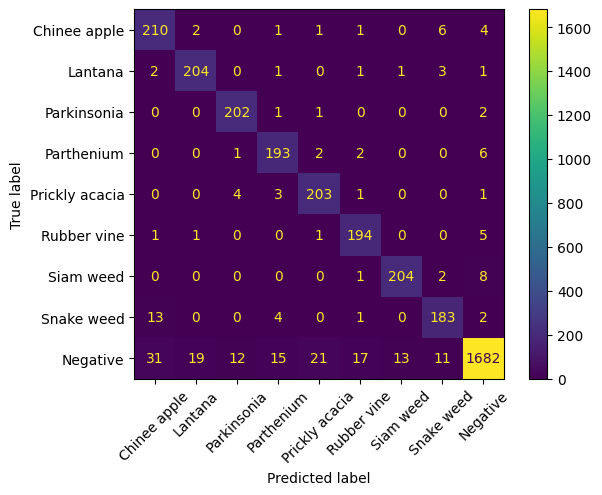

In [50]:
print("Evaluation with Random Guess - As applied by the paper DeepWeeds \
  \n--------------------------------------------------------------------")
printStats(a,b,rand_guess)

In [ ]:
shutil.rmtree(base_dir)